In [123]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import *
from qiskit.quantum_info import state_fidelity
import numpy as np
import matplotlib.pylab as plt
from qiskit.quantum_info import DensityMatrix
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer import StatevectorSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import depolarizing_error

In [138]:
def circuit(params,shots):

    n_qubits = len(params)
    layers = len(params[0])
    qc = QuantumCircuit(n_qubits)
    
    for layer in range(layers):
        for qubit in range(n_qubits):
            qc.rx(params[qubit][layer][0],qubit)
            qc.ry(params[qubit][layer][1],qubit)
        if(layer<1):
            qc.cx(0,1)
            qc.cx(1,0)
            
    qc.measure_all()
    # Create an empty noise model
    noise_model = NoiseModel()
    # Add depolarizing error to all single qubit u1, u2, u3, cx gates
    error1 = depolarizing_error(0.001, 1)
    error2 = depolarizing_error(0.01, 2)
    noise_model.add_all_qubit_quantum_error(error1, ['u1', 'u2', 'u3'])
    noise_model.add_all_qubit_quantum_error(error2, ['cx'])
    
    backend_sim = QasmSimulator()
    backend_options = {"method": "statevector"}
    job = execute(qc, backend_sim, basis_gates=noise_model.basis_gates,
     noise_model=noise_model, shots=shots)#, backend_options=backend_options)
    counts = job.result().get_counts()

    return counts

In [139]:
def cost(params,shots,target_state):
    
    counts=circuit(params,shots)
    
    # the error is designed to prioritize the minimisation of population in 00, 11 state and also make the
    # population in 01, 10 state equal 
    error = (abs(target_state['10']-counts.get('10',0))+abs(target_state['01']-counts.get('01',0))
        +2*abs(target_state['00']-counts.get('00',0))+2*abs(target_state['11']-counts.get('11',0)))/200

    error += 1.5*(abs(counts.get('10',0)-counts.get('01',0)))/200  

    return error

Quantum Gradient:

$$\frac{df}{d\theta }\,=\,\frac{1}{2}\,\left( f\left(\theta +\frac{\pi }{2} \right)-f\left(\theta -\frac{\pi }{2} \right) \right)$$

$\theta$ is the weights and $f$ is quantum unitary gate. 

In [140]:
def gradient(params,shots,target_state):

    g = np.zeros(params.shape)
    
    for qubit in range(len(params)):
        
        for layer in range(len(params[qubit])):
            
            for val in range(len(params[qubit][layer])):
                        
                params[qubit][layer][val] = params[qubit][layer][val]+np.pi/2
                
                F1 = cost(params,shots,target_state)
                
                params[qubit][layer][val] = params[qubit][layer][val]-np.pi
                    
                F2 = cost(params,shots,target_state)
                
                params[qubit][layer][val] = params[qubit][layer][val]+np.pi/2
                
                g[qubit][layer][val] = (F1-F2)/2
    return g

In [141]:
def optimize(params,shots,target_state,lr):
    g = gradient(params,shots,target_state)
    params = params - (lr*g)
    return params

In [142]:
np.random.seed(5) #to be reproducible 
params = np.random.rand(2,2,2) #(n_qubits,n_layers,n_weights)
target_state={'00': 0, '01': 50, '10': 50, '11': 0}
shots=100
loss = np.inf
lr = 0.25
test_loss = []
epochs = 300
#print(params)
for it in range(epochs):
    
    params = optimize(params,shots,target_state,lr)
    res = cost(params,shots,target_state)
    test_loss.append(res)

    # save best weights based on testing portion of the data    
    if res <= loss:
        loss = res
        var = params
    print("Epoch: {:2d} | testing loss: {:4f}".format(it+1,res))

Epoch:  1 | testing loss: 1.110000
Epoch:  2 | testing loss: 1.035000
Epoch:  3 | testing loss: 1.020000
Epoch:  4 | testing loss: 0.900000
Epoch:  5 | testing loss: 1.005000
Epoch:  6 | testing loss: 0.967500
Epoch:  7 | testing loss: 0.972500
Epoch:  8 | testing loss: 0.817500
Epoch:  9 | testing loss: 0.970000
Epoch: 10 | testing loss: 0.850000
Epoch: 11 | testing loss: 0.812500
Epoch: 12 | testing loss: 0.987500
Epoch: 13 | testing loss: 0.862500
Epoch: 14 | testing loss: 0.855000
Epoch: 15 | testing loss: 0.862500
Epoch: 16 | testing loss: 0.890000
Epoch: 17 | testing loss: 0.880000
Epoch: 18 | testing loss: 0.795000
Epoch: 19 | testing loss: 0.650000
Epoch: 20 | testing loss: 0.822500
Epoch: 21 | testing loss: 0.655000
Epoch: 22 | testing loss: 0.572500
Epoch: 23 | testing loss: 0.477500
Epoch: 24 | testing loss: 0.497500
Epoch: 25 | testing loss: 0.345000
Epoch: 26 | testing loss: 0.417500
Epoch: 27 | testing loss: 0.390000
Epoch: 28 | testing loss: 0.075000
Epoch: 29 | testing 

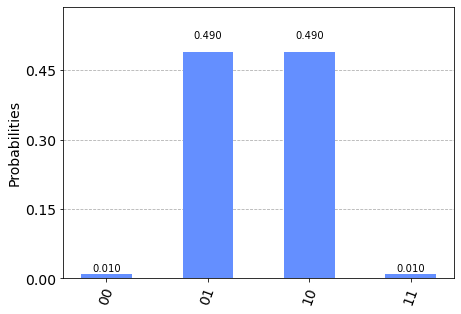

In [150]:
#testing the model (Running this block produces different result everytime due to random noise)
from qiskit.visualization import *
counts = circuit(var, shots)
plot_histogram(counts)